If we aggregate the predictions of a group of predictors (such as classifiers or regressors), we will often get better predictions thant with the best individual predictor.

A group of predictors is called an _ensemble_. _Ensemble Learning_ is the applied technique, while _Ensemble Method_ is an Ensemble Learning algorithm.

We will usually use Ensemble methods near the end of a project, once we have already built a few good predictors, to combine them into a better predictor.

# Voting Classifiers

Suppose we have multiple classifiers, all performing similarly: Logistic Regression, RFs, SVM, KNN

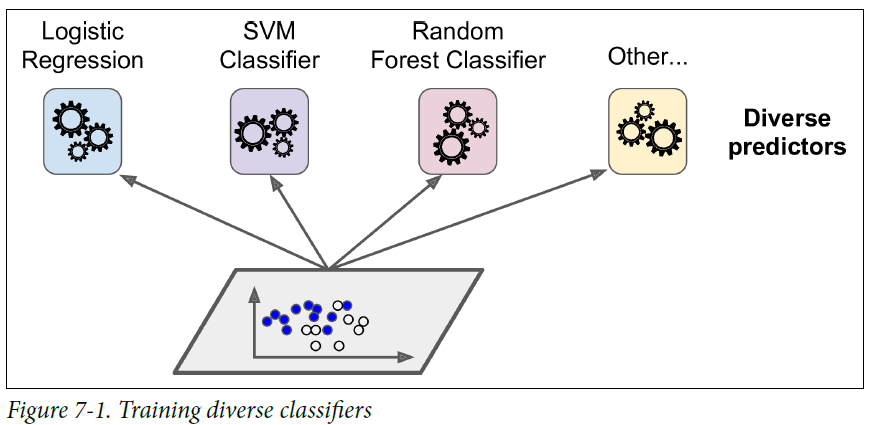

A simple approach to predict new instances is to aggregate the predictions of each classifier and choose the class that gets more votes &rarr; hard voting classifier

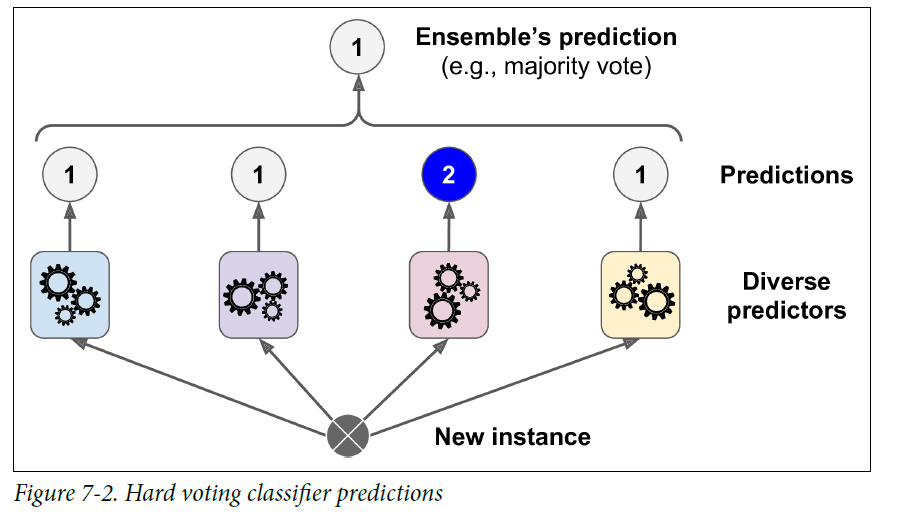

Often this voting classifier achieves a higher accuracy than the best classifier in the ensemble. Even if each classifier is a _weak learner_ (does slightly better than random guessing), the ensemble can still be a _strong learner_ .

Ensemble methods work best when the predictors are as independent from another as possible. One way to get diverse classifiers is to train them using very different algorithms, as they are more likely to make different type of errors, improving the essemble's accuracy.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

# Let’s look at each classifier’s accuracy on the test set:

>>> from sklearn.metrics import accuracy_score
>>> for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
... clf.fit(X_train, y_train)
... y_pred = clf.predict(X_test)
... print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

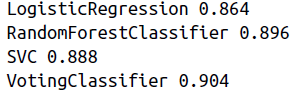

If all classfiers are able to estimate class probabilities (i.e., they have a dict_proba() method), then we can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers &rarr; <b>_soft voting_</b>

# Bagging and Pasting

Another approach is to use the same training algorithm for every predictor, but training them in different random subsets of the training set.

    When sampling is done with replacement, it is called bagging (bootstrap aggregating)
    
    When sampling is done without replacement, it is called pasting
    
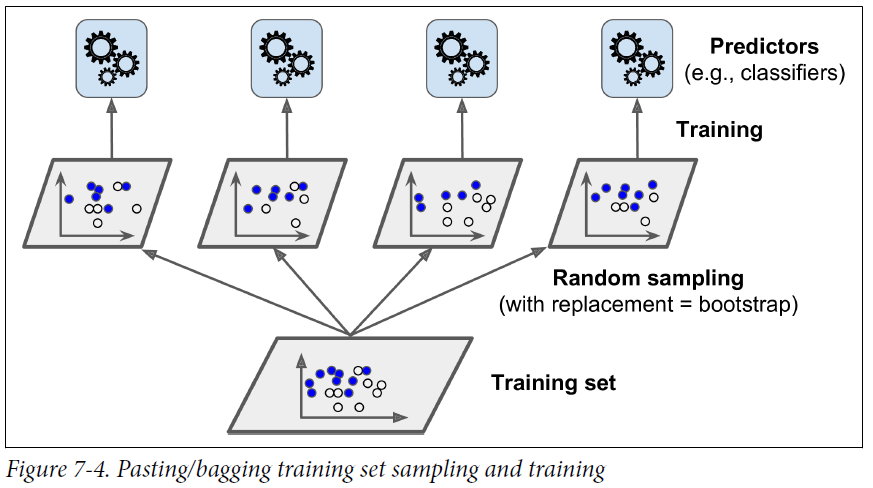


Once all predictors are trained, the ensemble makes a prediction for a new instance by aggregating the predicition of all classifiers &rarr; statistical mode &rarr; most frequent prediction (just like hard voting classifier) for classification, or the average for regression.


Each individual predictor has a higher bias than if it was trained on the original training set, but aggregation reduces both bias and variance

Bagging and pasting scale very well.

#### Bagging and Pasting in Scikit-Learn

BaggingClassifier class (or BaggingRegressor for regression).

In [1]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1) ## n_jobs: # CPU cores to use: if -1, then use all.

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

#The BagginClassifier automatically does soft voting if the base classifier 
#can estimate class probabilites (i.e., has predict_proba() method)

NameError: name 'X_train' is not defined

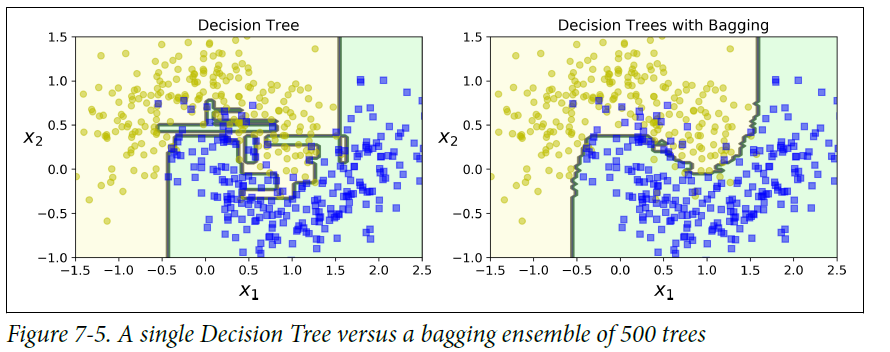

## Out-of-Bag evaluation

Bagging may cause some instances to be sampled several times, while others may not be sample at all: on average, 63% of the instances are sampled on each predictor. The remaining 37% are the _out-of\_-bag_instances.

The predictor can then be evaluated on the oob, without need of a separate validation set. The ensemble can also be evaluated by averaging out the oob evaluation of each predictor.

In [ ]:
>>> bag_clf = BaggingClassifier(
... DecisionTreeClassifier(), n_estimators=500,
... bootstrap=True, n_jobs=-1, oob_score=True) ###oob_score request an automatic evaluation after training
...
>>> bag_clf.fit(X_train, y_train)

>>> bag_clf.oob_score_
0.90133333333333332

# According to this oob evaluation, this BaggingClassifier is likely to achieve about
# 90.1% accuracy on the test set. Let’s verify this:
>>> from sklearn.metrics import accuracy_score
>>> y_pred = bag_clf.predict(X_test)
>>> accuracy_score(y_test, y_pred)
0.91200000000000003

## Random Patches and Random Subspaces

hyperparameters <b>_max\_features_</b> and <b>_bootstrap\_features_</b> &rarr; each predictor will be tained on a random subset of the input features.

Useful when dealing with high-dimensional inputs. Sampling both features and training instances is called _Random Patches_ method. Keeping all training instances but sampling features is called _Random Subspaces_ method.

# Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# For Regression: RandomForestRegressor

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

Decision Trees are easy to build, easy to use and easy to interpret. However, they do not generalize well. _Random Forest_ combines the simplicity of decision trees with flexibility resulting in a vast improvement in accuracy.

The Random Forest algorithm has all the hyperparameters of a DecisionTreeClassifier, plus all the parameters of a BaggingClassifier to control the ensemble.

### Extra Trees (ExtraTreesClassifier)

Beside the random subset of features for the node splits, it is also possible to make the tree even more random by using random thresholds for each feature rather than searching the best possible thresholds &rarr; _Extremely Randomized Tree_ ensemble

### Feature Importance

We can use feature_importances_ variable to check the weighted average score of how much a specific feature reduces the impurity

In [ ]:
>>> from sklearn.datasets import load_iris
>>> iris = load_iris()
>>> rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
>>> rnd_clf.fit(iris["data"], iris["target"])
>>> for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
... print(name, score)
...
sepal length (cm) 0.112492250999
sepal width (cm) 0.0231192882825
petal length (cm) 0.441030464364
petal width (cm) 0.423357996355

Random Forests are very handy to udnerstand which features matter, specially if feature selection is needed.

##  Building a Random Forest

### 1) Create a _bootstrapped_ dataset 

Randomly select samples from the original dataset, where we are allowed to pick the same sample more than once.

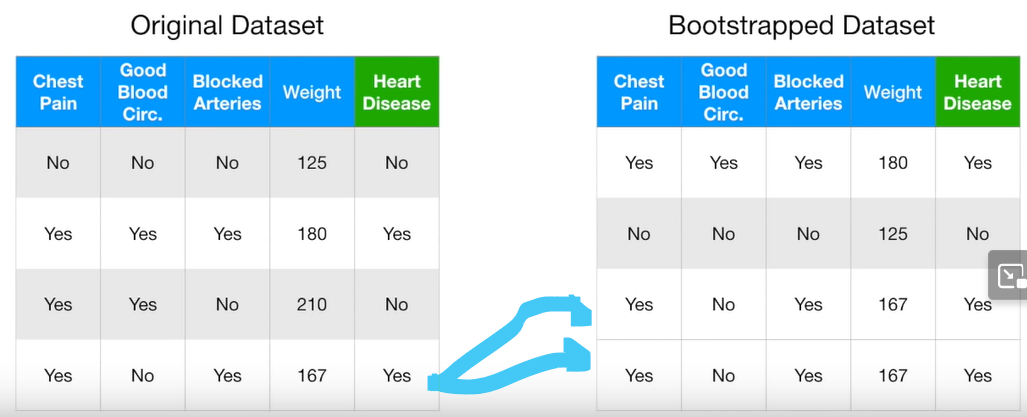

### 2) Create a decision tree using the bootstrapped dataset, but only use a random subset of variables (columns at each step)

Instead of considering all four variables to see which one splits the root node best, we randomly select two.

### 3) Go back to step 1 and repeat, making a bootstrapped dataset and build a decision tree on top of it, choosing a subset of variables at each step.

This variety of decision trees is what makes random forests more effective than individual trees

For a new sample, simply run it through all the trees and check the option with more votes. &rarr; <b>bootstrapping the data and using the aggregate to make a decision is called _bagging_</b>


## Evaluating the model

Check the _out-of-the-bag dataset_ &rarr; the samples that didn't end up being selected in the bagging phase. 

Run the out-of-the-bag samples through all the other trees that were built without it. <b>Ultimately, we can measure how accurate our random forest is by the proportion of out-of-the-bag samples that were correctly classified by the Random Forest.</b>

The proportion of out-of-bag samples that were incorrectly classified is the _out-of-the-bag error_.

We can also use the out-of-the-bag error to see the number of randomly selected variables that we should pick for each step.

## Missing Data and Clustering

RFs considers two types of missing data:

1) Missing data from the original dataset used to create the RF

2) Missing data in a new sample that you want to categorize.

#### Missing data from the original dataset

The general idea to deal with the missing data is to make an initial guess and gradually refine it until is a good guess.
 * Assign to the missing value the most common value for the variable (categorial), or the median value for numerical
 
To refine theses guesses, we first determine which samples are similar to the one with missing data: similar samples are samples that end up in the same leaf in the decision trees of the random forest.

We keep track of these similarities using a _Proximity Matrix_. It has a row and a column for each sample

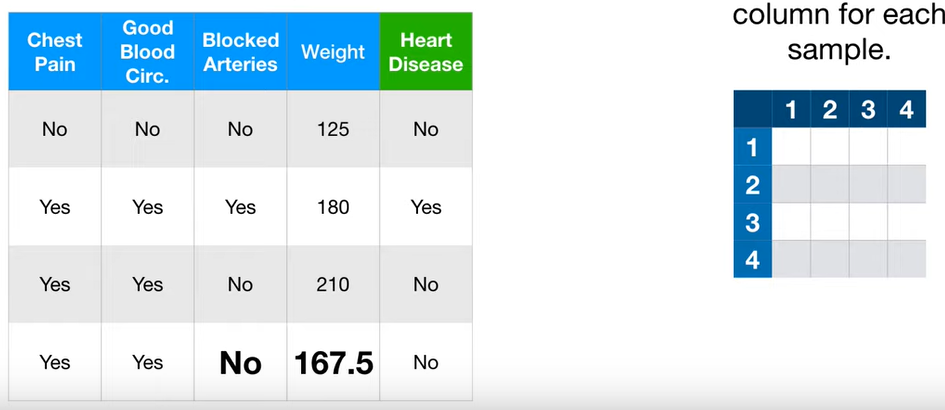



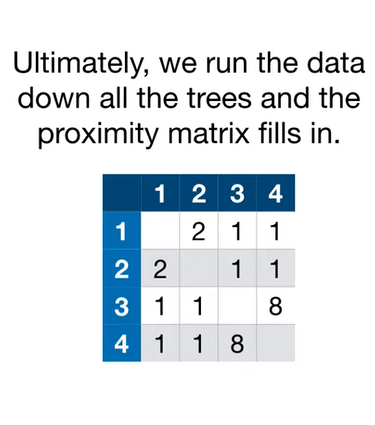

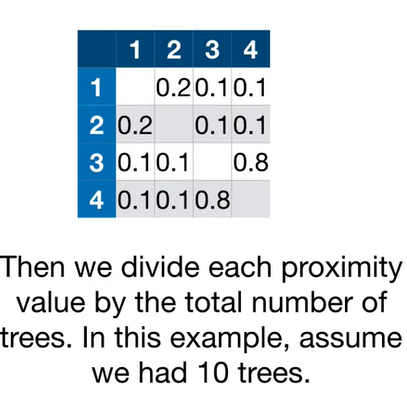

Now we use the proximity values for the sample with missing values to make better guesses about the missing data.